# Aggregating all of our data

With our parking, public transportation, and traffic data all cleaned and transformed, we can now aggregate it over DC census tracts, and use demographic data to come up with our final, and presentable data set.

In [139]:
import geopandas as gpd
import pandas as pd
import numpy as np

parking = gpd.read_file("../cleaned_data/cleaned_parking_zones.geojson")
public_transportation = gpd.read_file("../cleaned_data/public_transportation.geojson")
traffic = gpd.read_file("../cleaned_data/traffic_data.geojson")

#our new data sources
neighborhood_labels = gpd.read_file("../data/Neighborhood_Labels.geojson")
census_tracts = gpd.read_file("../data/Census_Tracts_in_2020.geojson")

dcBoundary = "../data/Washington_DC_Boundary_Stone_Area.geojson"
dcBoundary = gpd.read_file(dcBoundary)
dcBoundary = dcBoundary.to_crs(epsg=3857)


Transform, clean, and reduce data down to exactly what we need:

In [140]:
print(neighborhood_labels.columns)
print(census_tracts.columns)

Index(['OBJECTID', 'GIS_ID', 'NAME', 'WEB_URL', 'LABEL_NAME',
       'DATELASTMODIFIED', 'GLOBALID', 'CREATOR', 'CREATED', 'EDITOR',
       'EDITED', 'geometry'],
      dtype='str')
Index(['TRACT', 'GEOID', 'P0010001', 'P0010002', 'P0010003', 'P0010004',
       'P0010005', 'P0010006', 'P0010007', 'P0010008',
       ...
       'P0050005', 'P0050006', 'P0050007', 'P0050008', 'P0050009', 'P0050010',
       'OBJECTID', 'SHAPEAREA', 'SHAPELEN', 'geometry'],
      dtype='str', length=316)


In [141]:
neighborhood_labels = neighborhood_labels[["NAME", "geometry"]]
census_tracts = census_tracts[["TRACT", "P0010001", "geometry"]]

#rename columns for clarity
census_tracts = census_tracts.rename(columns={"P0010001": "POPULATION"})

## Basic (prelimenary) Visualization

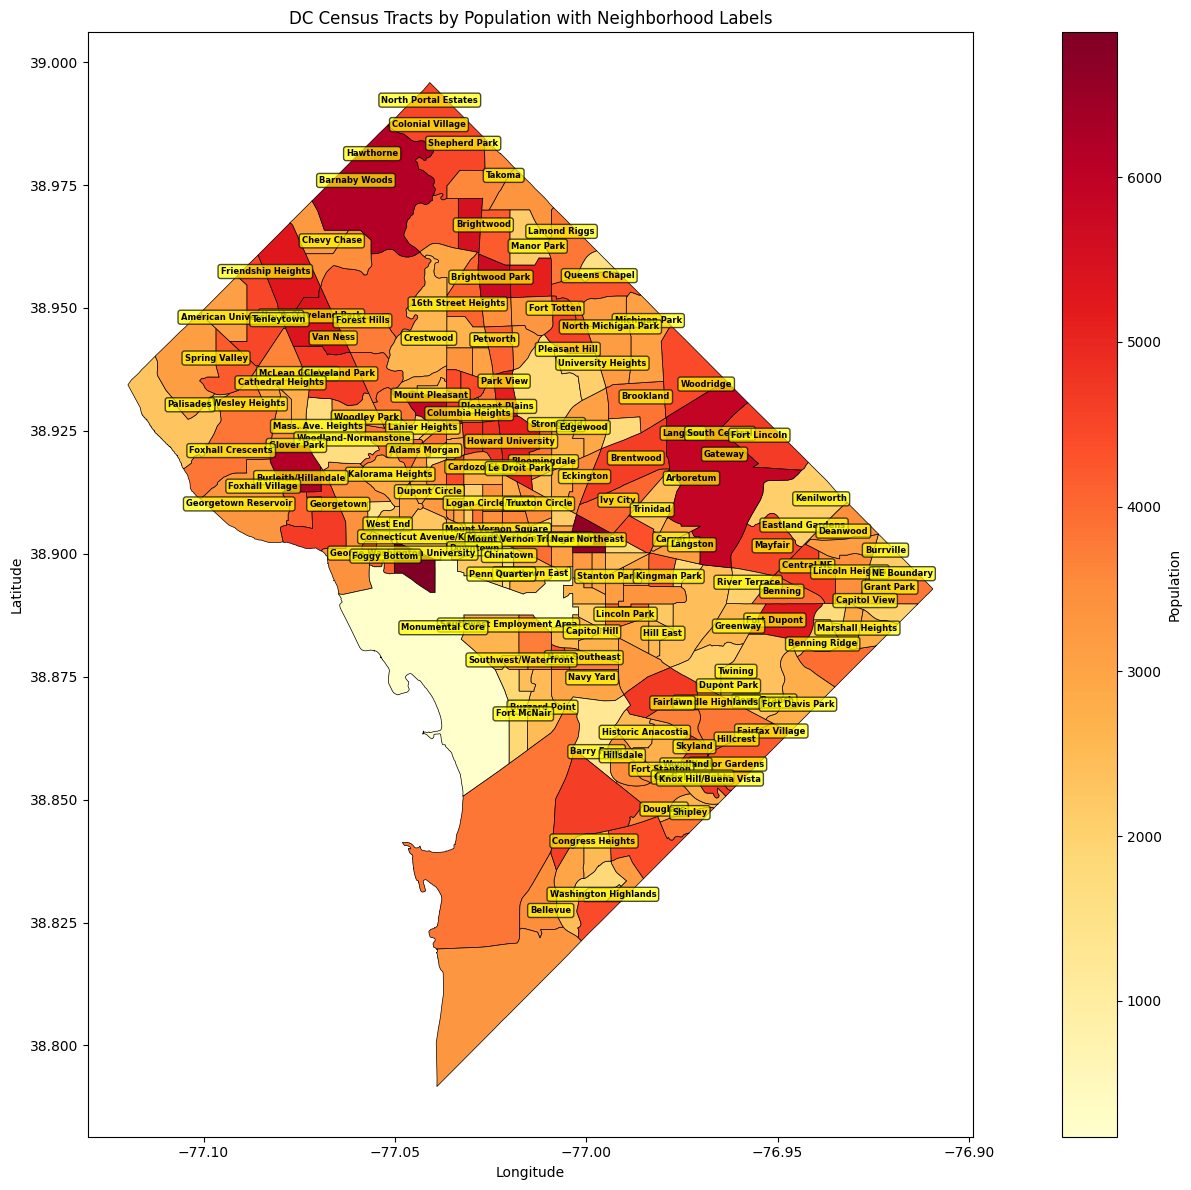

In [142]:
# visualize the lables and tracts, shading darker based on higher population, and using the labels to just label, use matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 12))

# Plot census tracts with population-based shading
census_tracts.plot(column='POPULATION', ax=ax, legend=True, 
				   cmap='YlOrRd', edgecolor='black', linewidth=0.5,
				   legend_kwds={'label': 'Population', 'orientation': 'vertical'})

# Overlay neighborhood labels as points with text annotations
for idx, row in neighborhood_labels.iterrows():
	ax.annotate(text=row['NAME'], xy=(row.geometry.x, row.geometry.y),
				ha='center', fontsize=6, weight='bold',
				bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('DC Census Tracts by Population with Neighborhood Labels')
plt.tight_layout()
plt.show()


## Aggregating Public Transportation Data by Census tract 

In [143]:
# Ensure both GeoDataFrames use the same CRS
census_tracts = census_tracts.to_crs(epsg=3857)
public_transportation = public_transportation.to_crs(epsg=3857)

# Spatial join: assign public transportation points to census tracts
joined = census_tracts.sjoin(public_transportation, how="left", predicate='contains')

# Count each type of public transportation per tract
counts = (joined.groupby(["TRACT", "TYPE"])
          .size()
          .unstack(fill_value=0)
          .reset_index())

# Merge counts back with population and geometry
census_tracts = census_tracts[["TRACT", "POPULATION", "geometry"]].merge(
    counts.rename(columns={
        "BUS STOP": "BUS_STOP_COUNT",
        "METRO STATION": "METRO_STATION_COUNT"
    }),
    on="TRACT",
    how="left"
)

# Aggregate by tract, keeping geometry
census_tracts = census_tracts.groupby(["TRACT", "geometry"]).agg({
    "POPULATION": "first",
    "BUS_STOP_COUNT": "sum",
    "METRO_STATION_COUNT": "sum"
}).reset_index()

# Convert back to GeoDataFrame if needed
census_tracts = gpd.GeoDataFrame(census_tracts, geometry="geometry", crs="EPSG:3857")

In [144]:
print(census_tracts.columns)

Index(['TRACT', 'geometry', 'POPULATION', 'BUS_STOP_COUNT',
       'METRO_STATION_COUNT'],
      dtype='str')


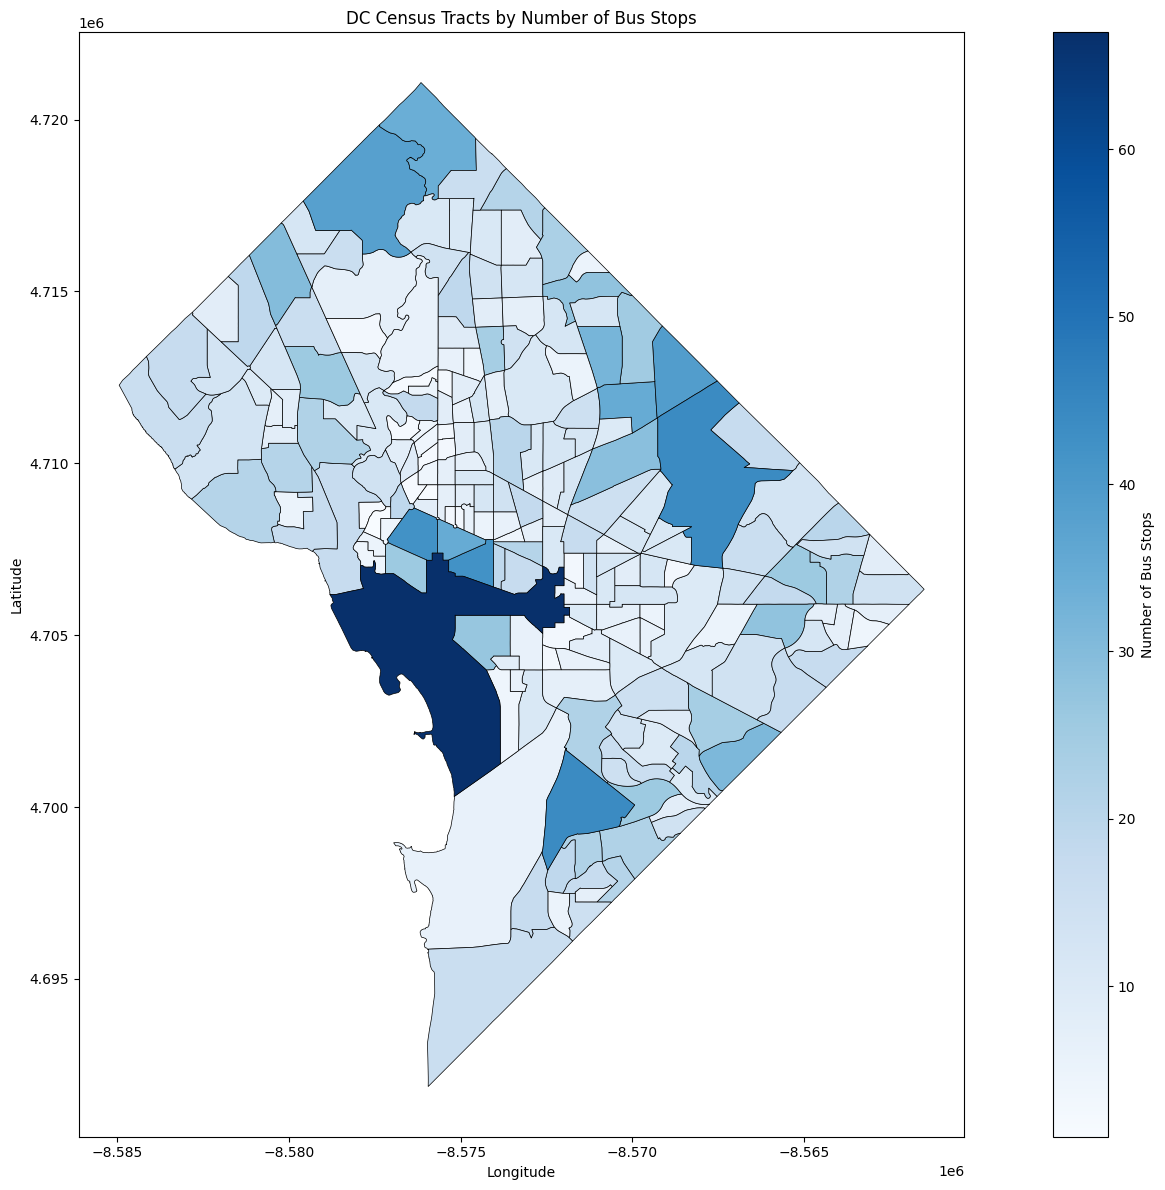

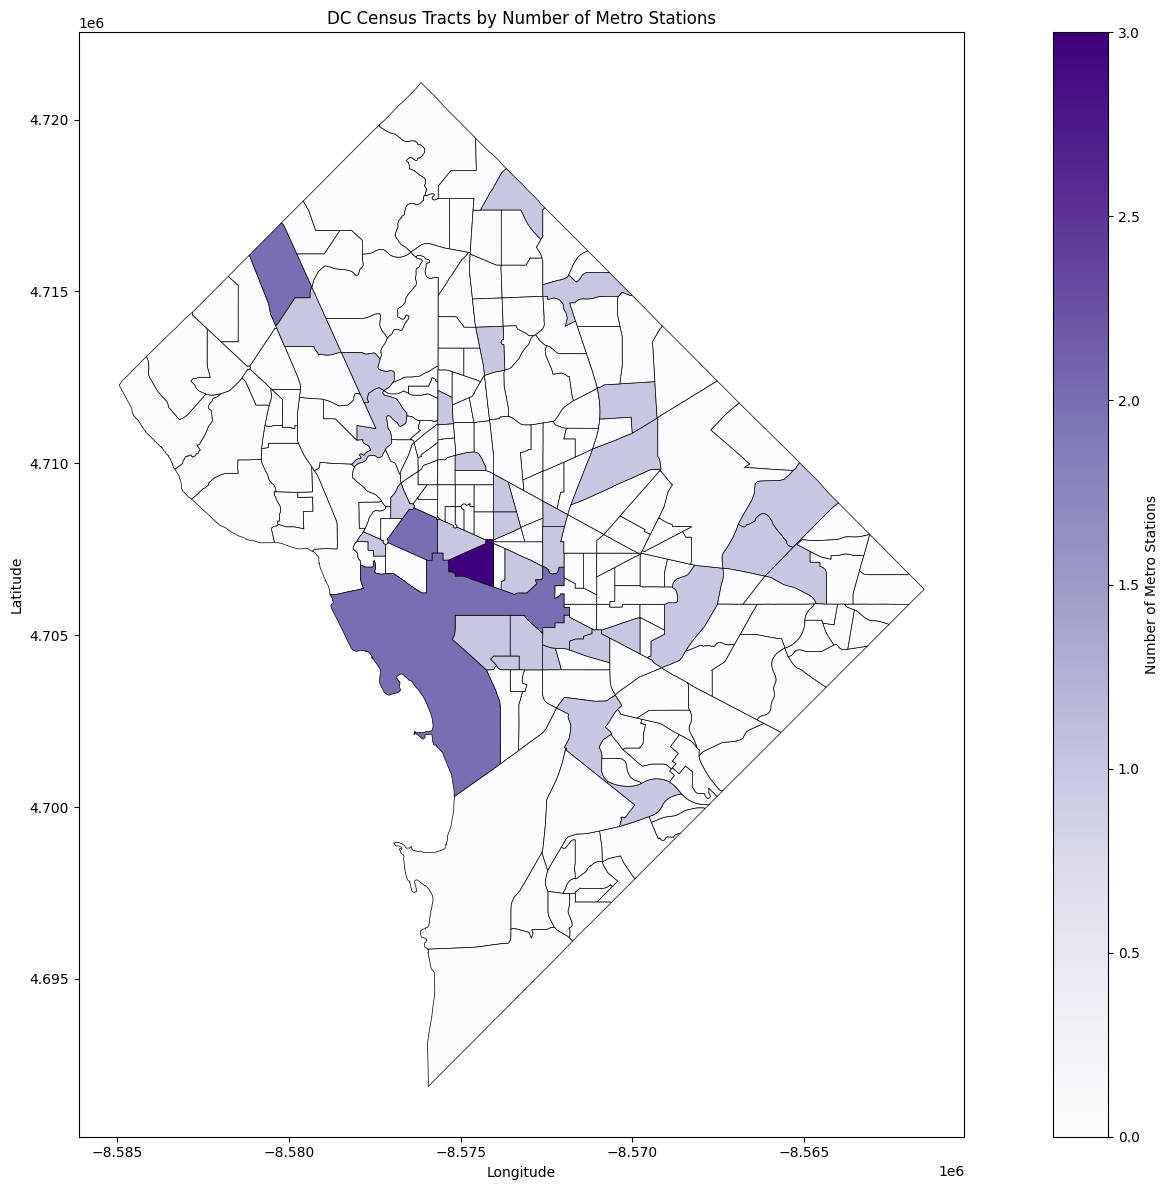

In [145]:
# Plot bus stops
fig, ax = plt.subplots(figsize=(18, 12))
census_tracts.plot(column='BUS_STOP_COUNT', ax=ax, legend=True, 
                   cmap='Blues', edgecolor='black', linewidth=0.5,
                   legend_kwds={'label': 'Number of Bus Stops', 'orientation': 'vertical'})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('DC Census Tracts by Number of Bus Stops')
plt.tight_layout()
plt.show()

# Plot metro stations
fig, ax = plt.subplots(figsize=(18, 12))
census_tracts.plot(column='METRO_STATION_COUNT', ax=ax, legend=True, 
                   cmap='Purples', edgecolor='black', linewidth=0.5,
                   legend_kwds={'label': 'Number of Metro Stations', 'orientation': 'vertical'})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('DC Census Tracts by Number of Metro Stations')
plt.tight_layout()
plt.show()

## Aggregating Traffic Data by Census tract

Here, we make sure to split the roads by census tracts, account for roads that might be cut off on the border, and then multiple the intersection ratio with traffic count for each census tract.

In [ ]:
# Aggregate traffic data by census tract and adjust counts by the share of each road within each tract.

# Ensure consistent CRS.
census_tracts_x = census_tracts.to_crs(epsg=3857)
traffic_x = traffic.to_crs(epsg=3857)

# Fix invalid geometries and remove duplicate tracts.
census_tracts_x["geometry"] = census_tracts_x.geometry.buffer(0)
census_tracts_x = census_tracts_x.drop_duplicates(subset=["TRACT"])

# Build DC boundary to clip roads.
dc_boundary = census_tracts_x.union_all()

traffic_x["geometry_road"] = traffic_x.geometry
traffic_x["geometry_road_clipped"] = traffic_x["geometry_road"].intersection(dc_boundary)

# Spatial join using intersects for line segments.
joined_traffic = census_tracts_x.sjoin(traffic_x, how="left", predicate="intersects")

# Remove duplicate road/tract pairs.
joined_traffic = joined_traffic.drop_duplicates(subset=["TRACT", "geometry_road"])

# Compute road lengths and intersection lengths per tract.
joined_traffic["road_length"] = joined_traffic["geometry_road_clipped"].length
joined_traffic["intersection_length"] = joined_traffic.apply(
    lambda row: row.geometry.intersection(row["geometry_road_clipped"]).length if pd.notnull(row["AADT"]) else 0,
    axis=1
)

# Adjust AADT by the share of each road within each tract.
joined_traffic["total_intersection_length"] = joined_traffic.groupby("geometry_road")["intersection_length"].transform("sum")
joined_traffic["adjusted_count"] = joined_traffic["AADT"] * (
    joined_traffic["intersection_length"] / joined_traffic["total_intersection_length"].replace(0, np.nan)
)
joined_traffic["adjusted_count"] = joined_traffic["adjusted_count"].fillna(0)

# Inspect intersection-to-road length ratios.
road_lengths = joined_traffic.groupby("geometry_road")["road_length"].max()
intersection_sums = joined_traffic.groupby("geometry_road")["intersection_length"].sum()
ratios = intersection_sums / road_lengths.replace(0, np.nan)
lengths_intersections = pd.DataFrame({
    "max_road_length": road_lengths,
    "sum_intersection_length": intersection_sums,
    "ratio": ratios
})

# Sum adjusted traffic counts per tract and merge back.
traffic_counts = joined_traffic.groupby("TRACT")["adjusted_count"].sum().reset_index()
traffic_counts = traffic_counts.rename(columns={"adjusted_count": "TOTAL_TRAFFIC_COUNT"})

census_tracts_x = census_tracts_x.merge(traffic_counts, on="TRACT", how="left")
census_tracts_x["TOTAL_TRAFFIC_COUNT"] = census_tracts_x["TOTAL_TRAFFIC_COUNT"].fillna(0)

census_tracts = gpd.GeoDataFrame(census_tracts_x, geometry="geometry", crs="EPSG:3857")


/var/folders/3m/17tpc1t17f75wznjzr3gj22w0000gn/T/ipykernel_81256/2005998582.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dc_boundary = census_tracts_x.unary_union


              ratio
count  8.530000e+03
mean   1.000000e+00
std    1.207496e-09
min    9.999999e-01
25%    1.000000e+00
50%    1.000000e+00
75%    1.000000e+00
max    1.000000e+00


## Basic Visulization

Overlay the roads themselves over our aggregated traffic data.

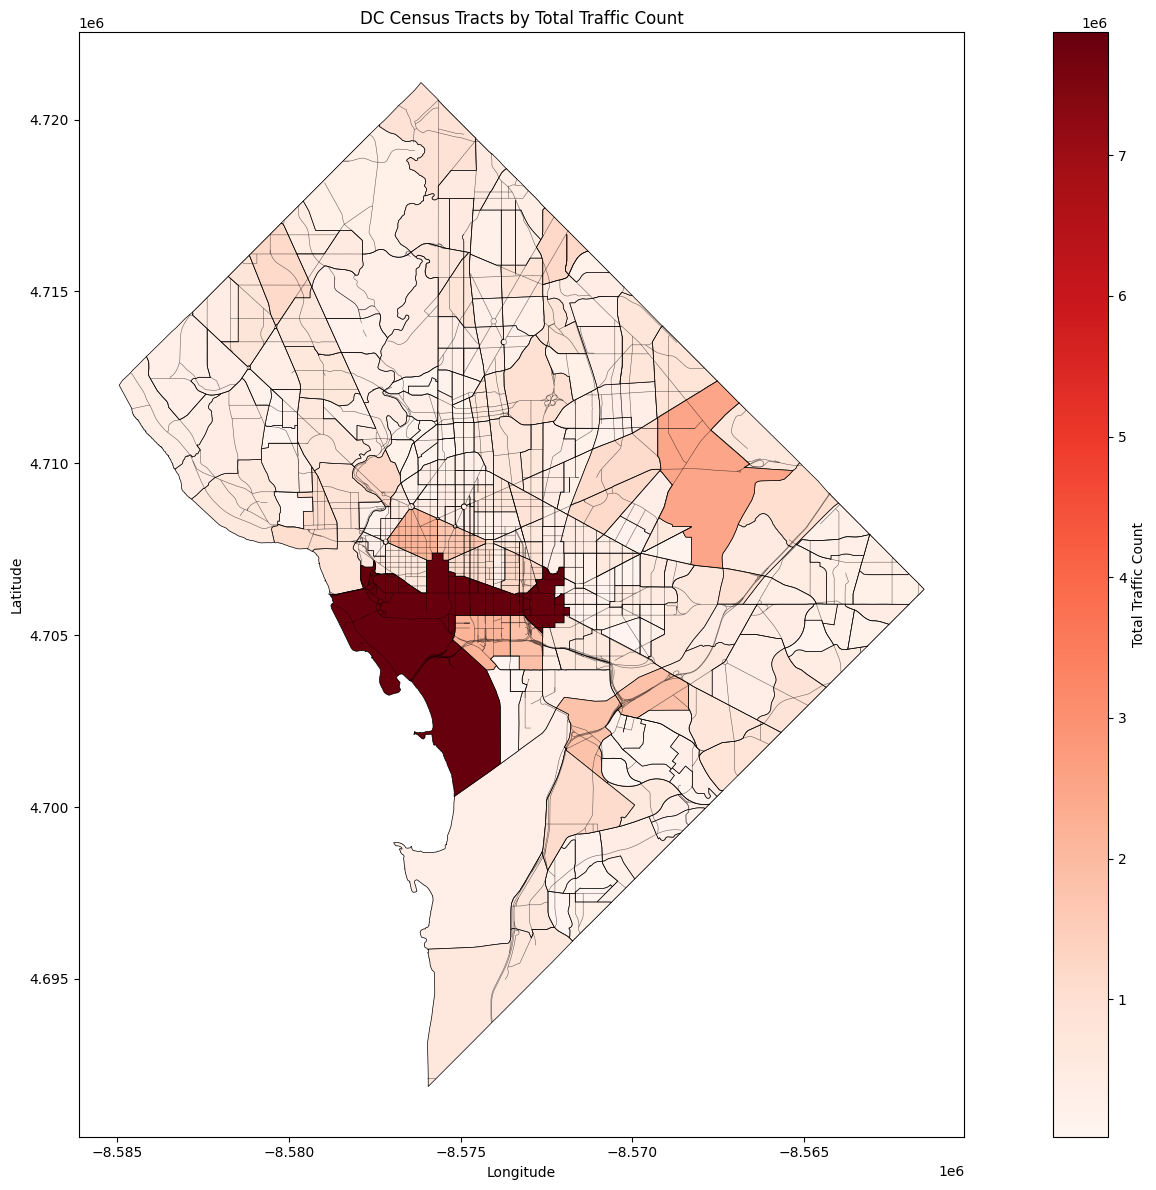

In [183]:
##plot traffic counts by tract, shading darker for higher traffic counts, and also plot the roads themselves from the traffic dataset, and also plot the roads themselves
fig, ax = plt.subplots(figsize=(18, 12))
census_tracts_x.plot(column='TOTAL_TRAFFIC_COUNT', ax=ax, legend=True, 
                   cmap='Reds', edgecolor='black', linewidth=0.5,
                   legend_kwds={'label': 'Total Traffic Count', 'orientation': 'vertical'})

# Overlay roads from the traffic dataset
traffic_x.plot(ax=ax, color='black', linewidth=0.4, alpha=0.6)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('DC Census Tracts by Total Traffic Count')
plt.tight_layout()
plt.show()

## Aggregating Parking Data

Similar process to working with traffic data, this time instead of just adding one column (traffic count) we add two: parking count, which we also make sure to adjust for intersection, as well as a parking score column field, that takes the parking count and unrestricted hours, and normalizes it.

In [ ]:
census_tracts_x = census_tracts.to_crs(epsg=3857)
parking_x = parking.to_crs(epsg=3857)

# Clean tract geometries and remove duplicate tracts to avoid duplicated intersections
census_tracts_x["geometry"] = census_tracts_x.geometry.buffer(0)
census_tracts_x = census_tracts_x.drop_duplicates(subset=["TRACT"])

# Build a unified DC boundary to clip parking segments at the border
dc_boundary = census_tracts_x.union_all()

# Preserve original geometry and clip parking segments to the DC boundary
parking_x["geometry_parking"] = parking_x.geometry
parking_x["geometry_parking_clipped"] = parking_x["geometry_parking"].intersection(dc_boundary)

# Spatially join parking segments to tracts using intersection
joined_parking = census_tracts_x.sjoin(
    parking_x,
    how="left",
    predicate="intersects"
)

# Remove duplicate parking/tract pairs to prevent inflated counts
joined_parking = joined_parking.drop_duplicates(subset=["TRACT", "geometry_parking"])

# Calculate clipped segment length and the portion within each tract
joined_parking["parking_length"] = joined_parking["geometry_parking_clipped"].length
joined_parking["intersection_length"] = joined_parking.apply(
    lambda row: row.geometry.intersection(row["geometry_parking_clipped"]).length
    if pd.notnull(row["ESTIMATED_MAX_CARS"]) else 0,
    axis=1
)

# Allocate estimated cars to each tract based on segment overlap share
joined_parking["total_intersection_length"] = joined_parking.groupby("geometry_parking")["intersection_length"].transform("sum")
joined_parking["adjusted_count"] = joined_parking["ESTIMATED_MAX_CARS"] * (
    joined_parking["intersection_length"] / joined_parking["total_intersection_length"].replace(0, np.nan)
)
joined_parking["adjusted_count"] = joined_parking["adjusted_count"].fillna(0)

# Compute parking score using estimated cars and unrestricted hours
joined_parking["PARKING_SCORE"] = (
    joined_parking["ESTIMATED_MAX_CARS"] * joined_parking["UNRESTRICTED_HOURS_PER_WEEK"]
)

score_min = joined_parking["PARKING_SCORE"].min()
score_max = joined_parking["PARKING_SCORE"].max()

# Normalize parking score to 0–100 across all segments
joined_parking["PARKING_SCORE"] = (
    (joined_parking["PARKING_SCORE"] - score_min) / (score_max - score_min) * 100
    if score_max != score_min
    else 0
)

# Sum total parking capacity per tract
parking_counts = (
    joined_parking.groupby("TRACT")["ESTIMATED_MAX_CARS"].sum().reset_index(name="MAX_TOTAL_PARKING_COUNT")
)
census_tracts_x = census_tracts_x.merge(parking_counts, on="TRACT", how="left")
census_tracts_x["MAX_TOTAL_PARKING_COUNT"] = census_tracts_x["MAX_TOTAL_PARKING_COUNT"].fillna(0)

# Compute weighted average parking score per tract (weighted by estimated cars)
parking_score_avg = (
    joined_parking.groupby("TRACT")
    .apply(lambda g: np.average(g["PARKING_SCORE"], weights=g["ESTIMATED_MAX_CARS"]))
    .reset_index(name="PARKING_SCORE")
)
parking_score_avg = parking_score_avg.rename(columns={"PARKING_SCORE": "PARKING_SCORE_AVG"})

census_tracts_x = census_tracts_x.merge(parking_score_avg, on="TRACT", how="left")
census_tracts_x["PARKING_SCORE_AVG"] = census_tracts_x["PARKING_SCORE_AVG"].fillna(0)

census_tracts = gpd.GeoDataFrame(census_tracts_x, geometry="geometry", crs="EPSG:3857")

## Basic Visualization

Plotting both parking score and parking count

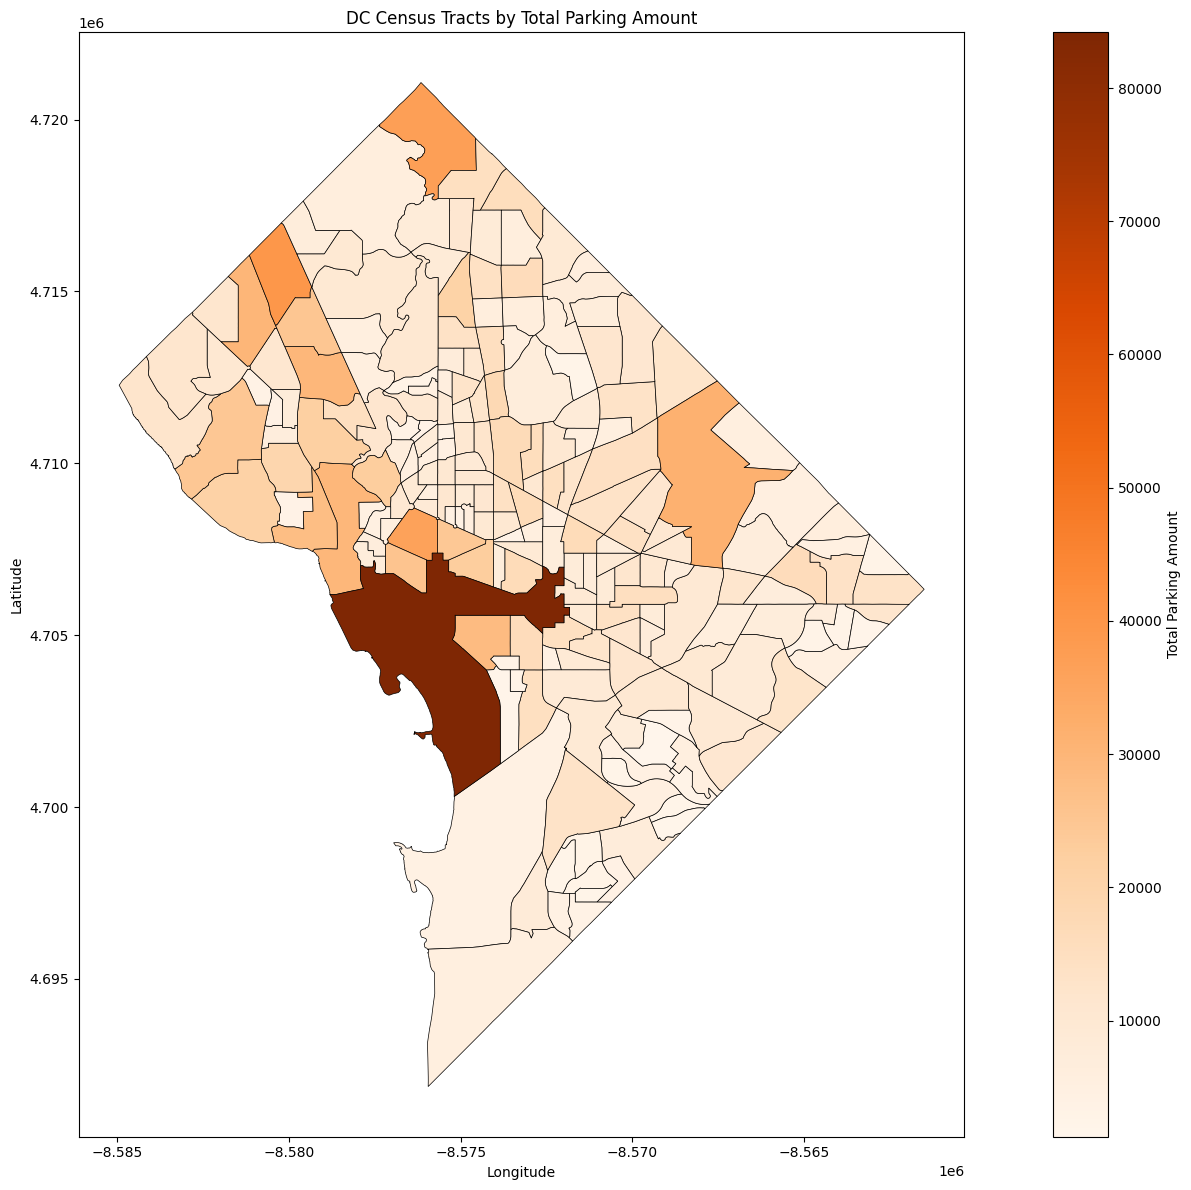

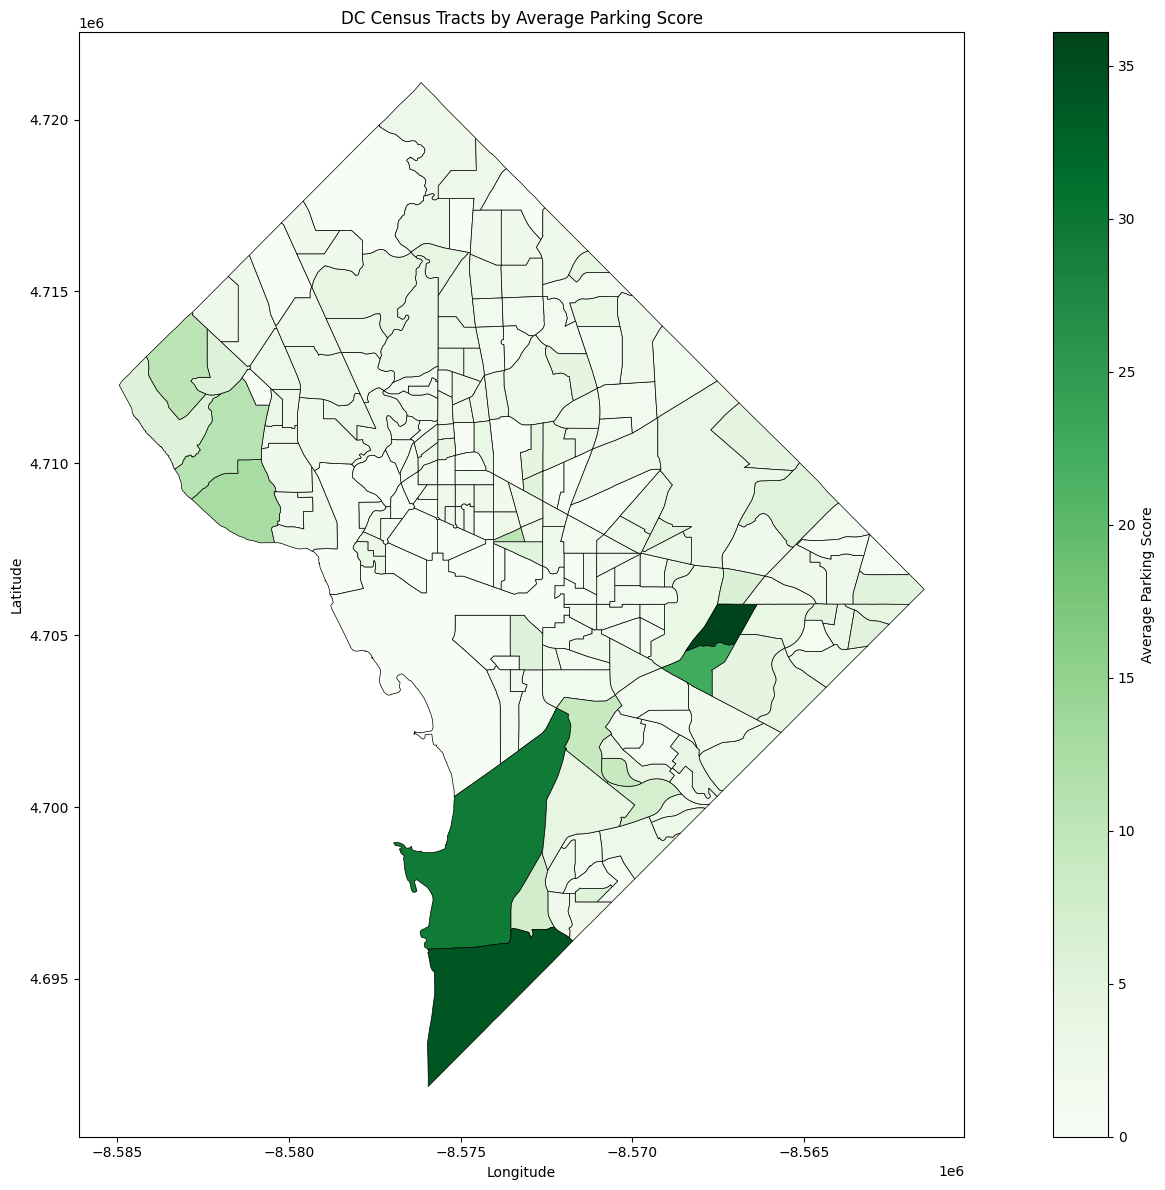

In [202]:
# Plot total parking amount by tract
fig, ax = plt.subplots(figsize=(18, 12))
census_tracts_x.plot(column='MAX_TOTAL_PARKING_COUNT', ax=ax, legend=True,
                     cmap='Oranges', edgecolor='black', linewidth=0.5,
                     legend_kwds={'label': 'Total Parking Amount', 'orientation': 'vertical'})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('DC Census Tracts by Total Parking Amount')
plt.tight_layout()
plt.show()

# Plot average parking score by tract
fig, ax = plt.subplots(figsize=(18, 12))
census_tracts_x.plot(column='PARKING_SCORE_AVG', ax=ax, legend=True,
                     cmap='Greens', edgecolor='black', linewidth=0.5,
                     legend_kwds={'label': 'Average Parking Score', 'orientation': 'vertical'})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('DC Census Tracts by Average Parking Score')
plt.tight_layout()
plt.show()

## Exporting our data

In [203]:
# export census tracts and neighborhood labels
census_tracts.to_file("../cleaned_data/census_tracts_with_labels.geojson", driver="GeoJSON")
neighborhood_labels.to_file("../cleaned_data/neighborhood_labels.geojson", driver="GeoJSON")